# Data Augmentation For Object Detection

This notebook serves as general manual to using this codebase. We cover all the major augmentations, as well as ways to combine them. 

In [203]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

In [222]:
path = 'images1/'
image_files = [f for f in os.listdir(path) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
print(len(image_files))
print(image_files[2])

FileNotFoundError: [Errno 2] No such file or directory: 'images1/'

In [223]:
import os, errno
FINAL_PATH = 'augumentedDataset/' + path
try:
    os.makedirs(FINAL_PATH)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [220]:
import random, string
FINAL_IMAGE_SIZE = 832

def convert_to_yolo_format(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def resize_and_write_to_disk(img, boxes):
    img_, boxes_ = Resize(FINAL_IMAGE_SIZE)(img, boxes)
#     plotted_img = draw_rect(img_, boxes_)
#     plt.imshow(plotted_img)
#     plt.show()
    name = FINAL_PATH + ''.join(random.choices(string.ascii_letters + string.digits, k=32))
    cv2.imwrite(name + '.jpg', img_)
    #back to YOLO conversion
    with open(name + '.txt','w') as annotation:
        height, width, channels = img_.shape
        for box in boxes_:
            (x, y, w, h) = convert_to_yolo_format([width, height], [box[0],box[2],box[1],box[3]])
            classId = int(box[4])
            line = str(classId) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h)
            print(line)
            if(box != boxes_[:-1]):
                line = line + '\n'
            annotation.write(line)
            
def make_train_text_valid_txt():
    image_files = [f for f in os.listdir(FINAL_PATH) if (f.endswith('.jpg') or f.endswith('.jpeg'))]
    try:
        os.makedirs('annotations/')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    with open('annotations/file.txt','w') as f:
        for image in image_files:
            line = 'data/images/' + image + '\n'
            f.write(line)
            
    lines = open('annotations/file.txt').readlines()
    random.shuffle(lines)
    open('annotations/shuffled.txt', 'w').writelines(lines)
    

In [224]:
# make_train_text_valid_txt()

## Storage Format 

First things first, we define how the storage formats required for images to work. 
1. **The Image**: A OpenCV numpy array, of shape *(H x W x C)*. 
2. **Annotations**: A numpy array of shape *N x 5* where *N* is the number of objects, one represented by each row. 5 columns represent the top-left x-coordinate, top-left y-coordinate, bottom-right x-coordinate, bottom-right y-coordinate, and the class of the object. 

Here is an image to aid your imagination. 

Whatever format your annotations are present in make sure, you convert them to this format.

For demonstration purposes, we will be using the image above to show the transformations. The image as well as it's annotation has been provided. The annotation is a numpy array in a pickled format. 

In [214]:
error_images = []
for image in image_files:
    try:
        img = cv2.imread(path + '/' + image)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
        height, width, channels = img.shape
        bboxes = []
        image_name = image.split(".")
        with open(path + '/' + image_name[0] + '.txt', 'r') as f:
            for line in f:
                c = line.split(" ")
                c[4] = c[4][:-2] #removing \n from the line 
        #         print(c)
                c = np.array(c)
                c = c.astype(np.float)
                x,y,w,h = c[1]*width, c[2]*height, c[3]*width, c[4]*height
                x1 = x - w/2
                y1 = y - h/2
                x2 = x + w/2
                y2 = y + h/2
                cl = c[0]
                bboxes.append([x1,y1,x2,y2,cl])
        bboxes = np.array(bboxes)
        bboxes = bboxes.astype(np.float)
        
        #all images are resized to final 608*608 keeping aspect ratios
        original_img, original_boxes = img, bboxes
        scaled_img, scaled_boxes = RandomScale(0.2, diff = True)(img.copy(), bboxes.copy())
        translated_img, translated_boxes = RandomTranslate(0.2, diff = True)(img.copy(), bboxes.copy())
        rotated_img, rotated_boxes = RandomRotate(30)(img.copy(), bboxes.copy())
        sheared_img, sheared_boxes = RandomShear(0.5)(img.copy(), bboxes.copy())
        hsv_img, hsv_boxes = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
        resize_and_write_to_disk(original_img, original_boxes)
        resize_and_write_to_disk(scaled_img, scaled_boxes)
        resize_and_write_to_disk(translated_img, translated_boxes)
        resize_and_write_to_disk(rotated_img, rotated_boxes)
        resize_and_write_to_disk(sheared_img, sheared_boxes)
        resize_and_write_to_disk(hsv_img, hsv_boxes)
    except FileNotFoundError:
        error_images.append(image)

0 0.5720000000000001 0.5367500000000001 0.836 0.07500000000000004
0 0.5808745594265937 0.47848529617070823 0.8398133811468126 0.06438712134256981
0 0.585984375 0.6219062500000001 0.8280312500000001 0.07500000000000004
0 0.5485247651134567 0.5419309957360172 0.6932572398529596 0.24052174597213577
0 0.5609147261257339 0.5367500000000001 0.7673944895185559 0.07500000000000004
0 0.5720000000000001 0.5367500000000001 0.836 0.07500000000000004


/home/himanshu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0 0.6530000000000001 0.48875 0.4920000000000001 0.08249999999999999
0 0.5309049785191963 0.5227586109326584 0.4000080389455506 0.09021329320122144
0 0.6733125000000001 0.3403125 0.492 0.08250000000000002
0 0.637931069553815 0.5113814991285945 0.45031629293895903 0.13402122327889096
0 0.6417131748684701 0.48875 0.46767340375678085 0.08249999999999999
0 0.6530000000000001 0.48875 0.4920000000000001 0.08249999999999999
0 0.5 0.44975000000000004 1.0 0.1125000000000001
0 0.50048828125 0.39968005167950477 1.0009765625 0.09515475231391622
0 0.416015625 0.43119531250000004 0.83203125 0.1125000000000001
0 0.5192705507464815 0.4707265976767719 0.7560248881987818 0.3789220526423342
0 0.5028332675206856 0.44975000000000004 0.9627132754202912 0.1125000000000001
0 0.5 0.44975000000000004 1.0 0.1125000000000001
0 0.5120000000000001 0.3755000000000001 0.663 0.0
0 0.48166556448602815 0.4063942222355172 0.550064558698385 0.1330147176195962
0 0.5513941322874674 0.3755000000000001 0.49341507067404394 0.0


0 0.659 0.49475 0.3899999999999999 0.059999999999999956
0 0.7093579251046028 0.49442391298894384 0.4198021104564417 0.05994708527203954
0 0.487125 0.62834375 0.3899999999999999 0.059999999999999956
0 0.6192901841183337 0.5428405211586257 0.3090238882448705 0.14982785524347716
0 0.6493826893480301 0.49475 0.369752668497866 0.059999999999999956
0 0.659 0.49475 0.3899999999999999 0.059999999999999956
0 0.5200000000000001 0.5165000000000001 0.516 0.14250000000000002
0 0.4534533235724502 0.5874725644850121 0.44996522108343145 0.16833292577040662
0 0.5004687500000001 0.5766562500000001 0.516 0.14249999999999993
0 0.5204794203567508 0.5053189410655753 0.43905739373616826 0.22945154869472617
0 0.5140743803935667 0.5165000000000001 0.47059906765828025 0.14250000000000002
0 0.5200000000000001 0.5165000000000001 0.516 0.14250000000000002
0 0.5350000000000001 0.5795 0.564 0.14249999999999993
0 0.533031390814475 0.6190408749438949 0.5619246811576895 0.1548973040253137
0 0.4396875 0.4716875000000000

0 0.6380000000000001 0.6020000000000001 0.7240000000000001 0.12000000000000005
0 0.6511199799385896 0.6462198151516345 0.6993225401228207 0.1311244817991532
0 0.653234375 0.5418437500000002 0.69353125 0.11999999999999998
0 0.6377597178893446 0.5535170217621375 0.6407929154219234 0.21980832596380992
0 0.637124406172006 0.6020000000000001 0.6133132441026589 0.12000000000000005
0 0.6380000000000001 0.6020000000000001 0.7240000000000001 0.12000000000000005
0 0.5090000000000001 0.4610000000000001 0.5410000000000001 0.0
0 0.4998913333810639 0.4686656008168074 0.46024526093627466 0.09651782520633452
0 0.5168707578498063 0.4610000000000001 0.43768133142061216 0.0
0 0.5090000000000001 0.4610000000000001 0.5410000000000001 0.0
0 0.5170000000000001 0.4745000000000001 0.5210000000000001 0.07499999999999998
0 0.4768436222286634 0.46100149034231896 0.48053293458633195 0.07210332410779378
0 0.4261796875000001 0.4354375000000001 0.5210000000000001 0.07499999999999998
0 0.5213566081807651 0.48899099416

0 0.462 0.47300000000000003 0.07000000000000002 0.66
0 0.40499542953247014 0.48168819075332575 0.06136294386855609 0.6764776031528591
0 0.2813359375 0.40491796875 0.06999999999999998 0.5598359375
0 0.46250406298485736 0.4940341895917259 0.2770549257921439 0.429762916635222
0 0.4622413499797811 0.47300000000000003 0.2548688973064808 0.66
0 0.462 0.47300000000000003 0.07000000000000002 0.66
0 0.5750000000000001 0.48424999999999996 0.55 0.05250000000000001
0 0.6792900164206281 0.5098499820257968 0.6429824671587439 0.05624112472193267
0 0.5960937500000001 0.47018750000000004 0.55 0.05250000000000001
0 0.5714585982168051 0.49229741404390004 0.518474778000327 0.09273973365714035
0 0.5687286794276439 0.48424999999999996 0.49041306452149214 0.05250000000000001
0 0.5750000000000001 0.48424999999999996 0.55 0.05250000000000001
0 0.56 0.5457500000000001 0.7240000000000001 0.3824999999999999
0 0.4798634825050109 0.6024816773593781 0.6203949309529069 0.43407425214488904
0 0.6382156862745099 0.42013

0 0.717 0.44075000000000003 0.545 0.08249999999999999
0 0.6014295399104405 0.49743966192946987 0.4571535554409903 0.0973120256822843
0 0.56153125 0.5579375000000001 0.5449999999999999 0.08250000000000013
0 0.7140105010521075 0.4493423096088265 0.5355302061988794 0.09517076700748599
0 0.6663829343748748 0.44075000000000003 0.470886585218509 0.08249999999999999
0 0.717 0.44075000000000003 0.545 0.08249999999999999
0 0.539 0.593 0.777 0.43500000000000005
0 0.4564364056761043 0.6129324128081869 0.6579797536369814 0.45352692216145585
0 0.37244140625 0.5295234375 0.7448828125 0.43500000000000005
0 0.5622323226832474 0.5440393985252768 0.7232247190252031 0.49440506228223596
0 0.4968961238069078 0.593 0.7262266645094765 0.43500000000000005
0 0.539 0.593 0.777 0.43500000000000005
0 0.551 0.47375000000000006 0.635 0.0675000000000001
0 0.44517426557183354 0.4971286280021768 0.5130411227551983 0.0720248957423568
0 0.6309632352941177 0.3358823529411765 0.635 0.0675000000000001
0 0.5473586624294425 

0 0.577 0.5720000000000001 0.48399999999999993 0.20250000000000004
0 0.6225246274139841 0.5740924731656953 0.5221870358203957 0.20344793247439227
0 0.5494264705882352 0.6963872549019609 0.484 0.20250000000000004
0 0.5718662220948844 0.5712920965638657 0.4776550510672822 0.21085784799188217
0 0.5786781869009129 0.5720000000000001 0.4638614120432356 0.20250000000000004
0 0.577 0.5720000000000001 0.48399999999999993 0.20250000000000004
0 0.49600000000000005 0.48050000000000004 0.633 0.059999999999999956
0 0.5431472630310336 0.5210945872434031 0.6931697933440408 0.06685140712968823
0 0.41299218750000005 0.41018750000000004 0.633 0.059999999999999956
0 0.5041111083244024 0.48705115852826864 0.4835917202475832 0.22472288328148893
0 0.49219666844308996 0.48050000000000004 0.5534496221279982 0.059999999999999956
0 0.49600000000000005 0.48050000000000004 0.633 0.059999999999999956
0 0.488 0.5322500000000001 0.487 0.05250000000000001
0 0.5715947429181856 0.5053802359509569 0.5704234422154842 0.0

0 0.49500000000000005 0.5105000000000001 0.562 0.06750000000000003
0 0.4525213584683505 0.5057501958068757 0.5137717241600263 0.0666683222229938
0 0.5907031250000001 0.5485859375000001 0.562 0.06750000000000003
0 0.4929751379162262 0.5056545841534028 0.4558931861125083 0.18809539137119824
0 0.49394455896809486 0.5105000000000001 0.4952910410505874 0.06750000000000003
0 0.49500000000000005 0.5105000000000001 0.562 0.06750000000000003
0 0.293 0.5165000000000001 0.586 0.2025000000000001
0 0.3079008558360945 0.5074742788082325 0.615801711672189 0.1978315235214996
0 0.2945625 0.4430625000000001 0.586 0.20250000000000004
0 0.3360292509798722 0.456244684741538 0.5126255955647447 0.28571560907786864
0 0.31960289320292323 0.5165000000000001 0.5484876075335219 0.2025000000000001
0 0.293 0.5165000000000001 0.586 0.2025000000000001
0 0.4530000000000001 0.5577500000000001 0.3900000000000001 0.05250000000000001
0 0.39727768193844487 0.6369894725953403 0.34202714339071416 0.06211310759388876
0 0.3451

0 0.447 0.4977500000000001 0.5720000000000001 0.09750000000000007
0 0.5010198152555941 0.4688522498073071 0.641126027575391 0.08994123234396365
0 0.5456328125000001 0.51728125 0.5720000000000001 0.09750000000000007
0 0.4474863532941343 0.4985250814097818 0.5677743480291123 0.10367285984570872
0 0.4571301508293611 0.4977500000000001 0.4928041123182858 0.09750000000000007
0 0.447 0.4977500000000001 0.5720000000000001 0.09750000000000007
0 0.532 0.449 0.525 0.07499999999999998
0 0.5558857496863151 0.5098623262618543 0.548571463506232 0.08908850144950327
0 0.6030937500000001 0.5974375000000001 0.5250000000000001 0.07499999999999998
0 0.5323167447652233 0.4501054914453904 0.5213610601921354 0.07997068323572767
0 0.5367815613701392 0.449 0.46705374033787816 0.07499999999999998
0 0.532 0.449 0.525 0.07499999999999998
0 0.48000000000000004 0.4805 0.7590000000000001 0.3
0 0.45870250226966763 0.45275942427856086 0.7253233317139121 0.2765902314587012
0 0.4527328431372549 0.4630367647058823 0.7590

0 0.5400000000000001 0.58025 0.5510000000000002 0.05250000000000008
0 0.6462145361555841 0.6128461322676972 0.6593781655957904 0.056259026785401636
0 0.5196875000000001 0.5427500000000001 0.5510000000000002 0.05250000000000008
0 0.5070119709943767 0.563199410039115 0.44326861533967044 0.17509732999064678
0 0.529692573010142 0.58025 0.518809877899551 0.05250000000000008
0 0.5400000000000001 0.58025 0.5510000000000002 0.05250000000000008
0 0.40800000000000003 0.48875 0.7100000000000001 0.14999999999999997
0 0.32967747671098585 0.5169737047015414 0.5737034521196078 0.16163864111403764
0 0.60565625 0.47624999999999995 0.71 0.14999999999999997
0 0.43408433244174766 0.46769695112358795 0.5856890618882681 0.2894691688409587
0 0.41500857387116036 0.48875 0.6628904634932007 0.14999999999999997
0 0.40800000000000003 0.48875 0.7100000000000001 0.14999999999999997
0 0.4480000000000002 0.55025 0.5890000000000001 0.04499999999999993
0 0.44986343901915044 0.5342861015389131 0.5914499231747312 0.04331

0 0.529 0.6200000000000001 0.696 0.044999999999999866
0 0.6076870881113943 0.5680400606796114 0.7861883237772115 0.04027636915269182
0 0.5836875000000001 0.6965625 0.696 0.04499999999999993
0 0.5570865884912719 0.5737619007539319 0.5601260810535085 0.20073038904371096
0 0.48875104003493963 0.6200000000000001 0.5606124355853344 0.044999999999999866
0 0.529 0.6200000000000001 0.696 0.044999999999999866
0 0.4139999999999999 0.37925000000000003 0.666 0.09
0 0.3571410171371464 0.4157619699602453 0.5745312014814964 0.10292459113637001
0 0.38979656862745093 0.3712843137254902 0.666 0.09
0 0.39999180725664485 0.4329080749944078 0.564152182541241 0.20870281022160386
0 0.44798231106334674 0.37925000000000003 0.5908169444456284 0.09
0 0.4139999999999999 0.37925000000000003 0.666 0.09
0 0.36400000000000005 0.521 0.7200000000000001 0.11250000000000003
0 0.33167196748937194 0.46055181508106596 0.6560544411877687 0.09532722019348475
0 0.3420000000000001 0.46725000000000005 0.6840000000000002 0.112500

0 0.465 0.4977499999999999 0.754 0.24000000000000002
0 0.4520671022322795 0.5455527636081059 0.7330292367379327 0.2707784393452593
0 0.6010294117647058 0.4487303921568627 0.754 0.2400000000000001
0 0.4750757059752406 0.4883654619393666 0.6389969265720475 0.3673091214883752
0 0.4706555562784609 0.4977499999999999 0.6752252199942902 0.24000000000000002
0 0.465 0.4977499999999999 0.754 0.24000000000000002
0 0.46799999999999997 0.43324999999999997 0.75 0.10499999999999995
0 0.44880186245870035 0.3767692102993104 0.7192337539402249 0.08576080156180889
0 0.374625 0.5377421874999999 0.74925 0.10499999999999995
0 0.46113959330244775 0.45090999483622546 0.6773174429880905 0.19433307767866403
0 0.45416307421517577 0.43324999999999997 0.606315380089707 0.10499999999999995
0 0.46799999999999997 0.43324999999999997 0.75 0.10499999999999995
0 0.5190000000000001 0.5795 0.8570000000000001 0.1050000000000001
0 0.5307656195511097 0.5809475353617184 0.8764280076210039 0.10533441410996797
0 0.416621093750

0 0.5520000000000002 0.6537499999999999 0.673 0.12749999999999992
0 0.515507638437883 0.5607510014475534 0.6285084070085059 0.10507470956891349
0 0.69222265625 0.6386132812499999 0.6155546875 0.12749999999999992
0 0.5521943005935265 0.6533672827500153 0.672545811024672 0.12832310796820953
0 0.5934677559280537 0.6537499999999999 0.5358467126753413 0.12749999999999992
0 0.5520000000000002 0.6537499999999999 0.673 0.12749999999999992
0 0.497 0.509 0.708 0.06000000000000009
0 0.503933662705415 0.5640806085168628 0.7178773303731062 0.06860634508075995
0 0.34786328125 0.5588046875 0.6957265625 0.06000000000000009
0 0.4983154193377675 0.5080234552140741 0.6531165055730797 0.1289119902776153
0 0.49994607475898817 0.509 0.5670909702820097 0.06000000000000009
0 0.497 0.509 0.708 0.06000000000000009
0 0.565 0.29600000000000004 0.572 0.045
0 0.6264963523363515 0.28437061151587917 0.6342582540467133 0.041939634609441855
0 0.5601171875 0.4102578125000001 0.572 0.045
0 0.5982438588697272 0.3601066671

0 0.481 0.6177500000000001 0.9280000000000002 0.17250000000000004
0 0.42234757001748874 0.5571564310088887 0.8148410498466311 0.15128763947038718
0 0.5475625 0.5786875000000001 0.9048750000000002 0.17250000000000004
0 0.4812007355795089 0.6175373454748289 0.928292682684672 0.17371963395991327
0 0.5281295389344974 0.6177500000000001 0.7396594734004709 0.17250000000000004
0 0.481 0.6177500000000001 0.9280000000000002 0.17250000000000004
0 0.493 0.44675 0.986 0.09750000000000002
0 0.5003125 0.44385229248955516 1.000625 0.09662190681501677
0 0.50875 0.528625 0.9825000000000002 0.09750000000000002
0 0.4774447433308092 0.4679858670205357 0.7784983111232469 0.3307527254534186
0 0.4777506464589059 0.44675 0.7859196937536159 0.09750000000000002
0 0.493 0.44675 0.986 0.09750000000000002
0 0.47100000000000003 0.54725 0.675 0.22500000000000006
0 0.4432140385244173 0.5676222453828659 0.6351793545732096 0.23585554816138501
0 0.4954140625 0.43396875 0.6750000000000002 0.225
0 0.4666180102382541 0.532

0 0.537 0.5705000000000001 0.3590000000000001 0.03749999999999999
0 0.49250640774414617 0.5826683222455941 0.32925474931126353 0.03852426954929248
0 0.49325 0.6486250000000001 0.3590000000000001 0.037500000000000054
0 0.5477649936600887 0.5418975694762167 0.3013783158597543 0.10503409247933926
0 0.5518662108888569 0.5705000000000001 0.2749851172101518 0.03749999999999999
0 0.537 0.5705000000000001 0.3590000000000001 0.03749999999999999
0 0.519 0.50975 0.8080000000000002 0.08249999999999999
0 0.4871302414900225 0.49651724269608527 0.7583838827050832 0.07966256665997928
0 0.5424375 0.554671875 0.8080000000000002 0.08249999999999999
0 0.5181184241015646 0.5041223494481164 0.7053679830553163 0.2055378899871442
0 0.512735426206072 0.50975 0.6747787218266964 0.08249999999999999
0 0.519 0.50975 0.8080000000000002 0.08249999999999999
0 0.53 0.5412500000000001 0.6970000000000001 0.08249999999999999
0 0.5132821614192623 0.5914943441117774 0.6750144651117467 0.09245833847260446
0 0.50734375000000

0 0.5164928443649375 0.4600000000000001 0.08726259689922478 0.4900000000000001
0 0.5095811702669945 0.3986340527996268 0.08524506491206633 0.42463192580829817
0 0.5484695885509839 0.5074806201550388 0.0872625968992247 0.4900000000000001
0 0.5171132455515517 0.4606335103037882 0.0924938975686433 0.4870775192296407
0 0.5060039039617648 0.4600000000000001 0.1338972619816491 0.4900000000000001
0 0.5164928443649375 0.4600000000000001 0.08726259689922478 0.4900000000000001
0 0.466 0.46250000000000013 0.8109999999999999 0.18000000000000008
0 0.5368224232347403 0.49192764079598855 0.9294801535305196 0.1956947417578606
0 0.6068125 0.31562500000000004 0.786375 0.18
0 0.46572974002539236 0.4639711564513299 0.8041867562331202 0.19083397985646577
0 0.4626133420539888 0.46250000000000013 0.7010946629905144 0.18000000000000008
0 0.466 0.46250000000000013 0.8109999999999999 0.18000000000000008
0 0.487 0.49100000000000005 0.765 0.07499999999999998
0 0.4173748365600784 0.4865771671485495 0.6556298767319

0 0.5209217731841645 0.2853505311451185 0.6229877768025036 0.11058657320353002
0 0.441 0.23584375000000005 0.647 0.10500000000000002
0 0.600182428553077 0.36550864541240485 0.5299154407483243 0.23747646241907674
0 0.5987821804569871 0.27725000000000005 0.5326273638183912 0.10500000000000002
0 0.541 0.27725000000000005 0.6470000000000001 0.10500000000000002
0 0.607 0.5345000000000001 0.34000000000000014 0.08250000000000006
0 0.5390764022900395 0.5358929875049401 0.30195383324318537 0.08278063850832126
0 0.554265625 0.64338671875 0.34000000000000014 0.08249999999999999
0 0.6030358705042382 0.5218853604781767 0.32505308049845094 0.10149762609918198
0 0.5678664761087526 0.5345000000000001 0.2810267415472449 0.08250000000000006
0 0.607 0.5345000000000001 0.34000000000000014 0.08250000000000006
0 0.52 0.48200000000000004 0.2589999999999999 0.037500000000000054
0 0.44872294437989446 0.441759448867629 0.2234985434507551 0.0332730513516417
0 0.4541299019607843 0.4743406862745098 0.2589999999999

0 0.44100000000000006 0.48275 0.6210000000000001 0.07499999999999998
0 0.3657554089941466 0.48281108746374174 0.5150433310325737 0.0750128065961723
0 0.30739062500000003 0.4061875 0.6147812500000001 0.07499999999999998
0 0.44239015117010744 0.4869616213342272 0.6007216344653641 0.1017620799197398
0 0.4478212080040789 0.48275 0.5201926626155569 0.07499999999999998
0 0.44100000000000006 0.48275 0.6210000000000001 0.07499999999999998
0 0.5150000000000001 0.5120000000000001 0.6820000000000002 0.059999999999999956
0 0.4877107592654552 0.49766214645077805 0.6458616268330883 0.057777076969112814
0 0.5798437500000001 0.5073125 0.682 0.059999999999999956
0 0.5136600693055805 0.5119512698668959 0.6561845535419557 0.09379681202917274
0 0.514512143207321 0.5120000000000001 0.6382210893831618 0.059999999999999956
0 0.5150000000000001 0.5120000000000001 0.6820000000000002 0.059999999999999956
0 0.586 0.4730000000000001 0.6840000000000002 0.07499999999999998
0 0.6260284713266667 0.4282546667874903 0.

0 0.532 0.5225000000000001 0.504 0.05250000000000001
0 0.5665043341584982 0.5094794404537529 0.5366883165712087 0.050780303456156015
0 0.6052421875 0.5605859375000001 0.504 0.05250000000000001
0 0.531909294645845 0.5182838884668773 0.48114139871741096 0.08210734269675601
0 0.5259409764390737 0.5225000000000001 0.4611213079117864 0.05250000000000001
0 0.532 0.5225000000000001 0.504 0.05250000000000001
0 0.564 0.48650000000000004 0.6050000000000001 0.06750000000000003
0 0.5765221699615971 0.5126368241628901 0.618432469551004 0.07238031986444013
0 0.4539999999999999 0.48275000000000007 0.605 0.06750000000000003
0 0.5424498651887261 0.47310142536395255 0.4696832782694107 0.21746756927691643
0 0.5558131479866708 0.48650000000000004 0.556435812680413 0.06750000000000003
0 0.564 0.48650000000000004 0.6050000000000001 0.06750000000000003
0 0.4925 0.423 0.09149999999999998 0.4000000000000001
0 0.4625324684955408 0.3882784511384998 0.08403869623766522 0.36716638405531893
0 0.4150260416666667 0.5

0 0.6060000000000001 0.68675 0.32799999999999996 0.09000000000000014
0 0.6568754063984841 0.74318312101538 0.35553652359521903 0.09904135450179666
0 0.54428125 0.546125 0.32799999999999996 0.09000000000000007
0 0.550930510856828 0.6604701673600896 0.2958478894277772 0.1285011468575046
0 0.5304644033771836 0.68675 0.28398673906398475 0.09000000000000014
0 0.6060000000000001 0.68675 0.32799999999999996 0.09000000000000014
0 0.585 0.49625 0.2110000000000001 0.045
0 0.6614771530837898 0.4310188387182016 0.23858406718064903 0.03709319257190326
0 0.5126960784313725 0.5060539215686274 0.21099999999999997 0.04500000000000007
0 0.5813770324984633 0.5015131933450965 0.20416753626900608 0.053843647344648506
0 0.571839158127913 0.49625 0.18589530632367088 0.045
0 0.585 0.49625 0.2110000000000001 0.045
0 0.6130000000000001 0.5465000000000002 0.4360000000000001 0.06750000000000003
0 0.5268456069530604 0.5894823807335623 0.3747221608997298 0.07438329940573066
0 0.43721875000000004 0.5715000000000001 

0 0.5860000000000001 0.5082500000000001 0.5960000000000001 0.05250000000000001
0 0.6648529524161977 0.567646729701209 0.6718565951676047 0.060636538315234134
0 0.5024062499999999 0.3598125 0.5960000000000001 0.05249999999999994
0 0.5569119181529171 0.5325998501702117 0.43832179831031415 0.2232708846343324
0 0.5742442216850338 0.5082500000000001 0.5303074349278961 0.05250000000000001
0 0.5860000000000001 0.5082500000000001 0.5960000000000001 0.05250000000000001
0 0.558 0.49474999999999997 0.6550000000000002 0.09000000000000007
0 0.46604040318730616 0.4736827846933346 0.5470545951392214 0.08487207741014234
0 0.7090000000000001 0.460375 0.5820000000000001 0.09
0 0.5572843939532868 0.4959633397107596 0.6474989471557707 0.10003443569447383
0 0.549826180462287 0.49474999999999997 0.5919003624314998 0.09000000000000007
0 0.558 0.49474999999999997 0.6550000000000002 0.09000000000000007
0 0.514 0.5442500000000001 0.692 0.1125000000000001
0 0.5902607580151958 0.6098553570404743 0.794670125576878

0 0.377 0.5200000000000001 0.031500000000000035 0.30000000000000004
0 0.40603643110122806 0.48051507715479436 0.035129553887653486 0.2772202368200737
0 0.32621875 0.41140625000000003 0.031500000000000035 0.30000000000000004
0 0.41576440706514567 0.5459736432546057 0.08591730707667156 0.25355748985475923
0 0.4140434341789088 0.5200000000000001 0.08397798825235049 0.30000000000000004
0 0.377 0.5200000000000001 0.031500000000000035 0.30000000000000004
0 0.5820000000000001 0.4655000000000001 0.611 0.03749999999999999
0 0.49543902799498635 0.4225481383186441 0.5201258524139806 0.032769618757559904
0 0.6132500000000001 0.4686250000000001 0.611 0.03749999999999999
0 0.5484566279573013 0.4550215466956724 0.46411807507713604 0.20053512125915324
0 0.5735853584753017 0.4655000000000001 0.4784038470809764 0.03749999999999999
0 0.5820000000000001 0.4655000000000001 0.611 0.03749999999999999
0 0.582 0.5720000000000001 0.516 0.1050000000000001
0 0.4842552102189546 0.659617034560553 0.4293396709157742

0 0.469 0.58775 0.6429999999999999 0.06750000000000003
0 0.37869443359157895 0.5762679145595598 0.5191908759048727 0.06582514150787759
0 0.5229062499999999 0.6104062499999999 0.643 0.06750000000000003
0 0.4691238137843603 0.5876938073554218 0.6425742446678899 0.0681593155238324
0 0.5024868954618863 0.58775 0.5161704967957798 0.06750000000000003
0 0.469 0.58775 0.6429999999999999 0.06750000000000003
0 0.598 0.48200000000000004 0.6490000000000001 0.135
0 0.5896550265577517 0.48523412143452976 0.6399433314982959 0.13665852381257937
0 0.6266458333333333 0.5695 0.649 0.13500000000000006
0 0.5768167141211329 0.4678390146257574 0.5824840798922474 0.2227592567288977
0 0.5959953933849477 0.48200000000000004 0.6343770426884362 0.135
0 0.598 0.48200000000000004 0.6490000000000001 0.135
0 0.577 0.5225000000000001 0.47100000000000003 0.05250000000000001
0 0.6899565671511755 0.5139677365348938 0.5632054473625714 0.05137309727819353
0 0.5441875 0.60296875 0.4710000000000001 0.05249999999999994
0 0.57

0 0.507 0.587 0.5879999999999999 0.0
0 0.503357549232299 0.5827927820666399 0.5707911115634723 0.022702026440683747
0 0.4976045438676059 0.587 0.5421223358638673 0.0
0 0.507 0.587 0.5879999999999999 0.0
0 0.493 0.38149999999999995 0.5440000000000002 0.11250000000000003
0 0.512782561850117 0.3558178693102318 0.5658290337656464 0.1012359075922069
0 0.42314705882352943 0.23199019607843135 0.5440000000000002 0.1125
0 0.48450133790160443 0.39332168682011476 0.5219405330253238 0.14086559346412156
0 0.5002091410140432 0.38149999999999995 0.5265461687775593 0.11250000000000003
0 0.493 0.38149999999999995 0.5440000000000002 0.11250000000000003
0 0.5440000000000002 0.46325000000000005 0.68 0.07499999999999998
0 0.5797491818955143 0.475264017283876 0.7246864773693927 0.07766386192547137
0 0.41587500000000005 0.34059375000000003 0.68 0.07500000000000004
0 0.5253276557552199 0.46440659290847297 0.5637514986897357 0.2093857838384605
0 0.5440290712753324 0.46325000000000005 0.6764460670490635 0.07499

0 0.336 0.401 0.672 0.09750000000000002
0 0.2852588533369246 0.453156341625392 0.5705177066738492 0.1159247945959266
0 0.3225451388888889 0.352171875 0.6450902777777778 0.09750000000000004
0 0.37113267409049744 0.3963561440203609 0.6077006445527295 0.17605835550923915
0 0.3870091576765513 0.401 0.5786088534700368 0.09750000000000002
0 0.336 0.401 0.672 0.09750000000000002
0 0.5110000000000001 0.5487500000000001 0.54 0.11250000000000003
0 0.4838907909227722 0.5674339062214451 0.5113523035191722 0.11746032908533936
0 0.5594375000000001 0.633125 0.5400000000000001 0.11249999999999996
0 0.5203051558565143 0.533402637679731 0.4734997718200193 0.19143915448294813
0 0.5204525339595892 0.5487500000000001 0.468425072074778 0.11250000000000003
0 0.5110000000000001 0.5487500000000001 0.54 0.11250000000000003
0 0.524 0.521 0.908 0.06750000000000003
0 0.5386457880076837 0.48460430767189716 0.9246615489846327 0.06129618880770976
0 0.59115234375 0.6049843750000001 0.8176953125 0.06750000000000017
0 0

0 0.577 0.44675000000000004 0.6020000000000001 0.045
0 0.6209908872522064 0.49954513915401855 0.6478969048974492 0.05238393554601657
0 0.6869999999999999 0.35737500000000005 0.602 0.045
0 0.567998359240852 0.44626358763545754 0.5691342114021138 0.08709651269352331
0 0.5617248979831636 0.44675000000000004 0.547396614599578 0.045
0 0.577 0.44675000000000004 0.6020000000000001 0.045
0 0.533 0.5900000000000001 0.5890000000000001 0.05250000000000008
0 0.5341275669260677 0.6412207985263935 0.5902460354961611 0.05828299338201224
0 0.7058002450980393 0.5440441176470588 0.5883995098039216 0.05250000000000008
0 0.5350039178266384 0.5853967096858222 0.577096992254772 0.068147232597589
0 0.5525838248679912 0.5900000000000001 0.47118020533049254 0.05250000000000008
0 0.533 0.5900000000000001 0.5890000000000001 0.05250000000000008
0 0.576 0.55625 0.6679999999999999 0.12000000000000005
0 0.6352250853287453 0.6012649762766556 0.7305263918425096 0.13252590644219983
0 0.7076699218750001 0.50498046875 0.

0 0.505 0.59375 0.6940000000000001 0.1875
0 0.40661788264567555 0.6013061157350318 0.5587976446655422 0.1905224462940127
0 0.5762890625000001 0.4716796875 0.6940000000000001 0.1875
0 0.5260758032128309 0.5670102498872448 0.6164798515241723 0.27901967311583614
0 0.49834212258491184 0.59375 0.6720365753443908 0.1875
0 0.505 0.59375 0.6940000000000001 0.1875
0 0.6170000000000001 0.49625 0.29499999999999993 0.28500000000000014
0 0.5931663432830462 0.569709820025949 0.2836046535956216 0.34139339719163775
0 0.4373125 0.42125000000000007 0.29499999999999993 0.2850000000000001
0 0.5946909149359378 0.5243293363639628 0.3119966272304461 0.26551553236233394
0 0.6107764584631749 0.49625 0.29966835725069824 0.28500000000000014
0 0.6170000000000001 0.49625 0.29499999999999993 0.28500000000000014
0 0.48200000000000004 0.51875 0.6210000000000001 0.2550000000000001
0 0.41753522328703385 0.5768428326407078 0.5379447586332946 0.292622024948268
0 0.5892303921568628 0.46973039215686274 0.6210000000000001 0

0 0.3948758799433144 0.7130000000000001 0.7457876143667003 0.32249999999999995
0 0.4600000000000001 0.7130000000000001 0.86 0.32249999999999995
0 0.5890000000000001 0.66875 0.821 0.08250000000000013
0 0.5303281971613962 0.7724613686317133 0.7392180812725065 0.09823551799929439
0 0.630265625 0.5251953125 0.7394687500000001 0.08250000000000006
0 0.5277476409873573 0.6381245290025008 0.6825941767117746 0.24325983164740447
0 0.6222417463083524 0.66875 0.6450754157652474 0.08250000000000013
0 0.5890000000000001 0.66875 0.821 0.08250000000000013
0 0.503 0.58625 0.515 0.11249999999999996
0 0.5336920800562918 0.5084353569121983 0.546424296677913 0.09352081875907269
0 0.5434411764705882 0.6012622549019608 0.515 0.11249999999999996
0 0.5081088163138636 0.5793379510980712 0.4983619740499609 0.13396897550885145
0 0.5022446716190793 0.58625 0.5129638282914625 0.11249999999999996
0 0.503 0.58625 0.515 0.11249999999999996
0 0.443 0.56075 0.5590000000000002 0.09000000000000007
0 0.4524748779581012 0.4

0 0.576 0.47525000000000006 0.6260000000000001 0.059999999999999956
0 0.5629798088036051 0.45382490855913193 0.6118495838733626 0.05632974878957284
0 0.531078125 0.6129453125000001 0.6260000000000001 0.05999999999999989
0 0.5689540887472637 0.49647109921045274 0.536349094409464 0.16633025246028035
0 0.5724468747134777 0.47525000000000006 0.5784273059160842 0.059999999999999956
0 0.576 0.47525000000000006 0.6260000000000001 0.059999999999999956
0 0.38000000000000006 0.34775 0.6830000000000003 0.21750000000000003
0 0.4117302529027438 0.3311449000519052 0.7400309545594054 0.2012862660439478
0 0.3007500000000001 0.31900000000000006 0.6015000000000001 0.21750000000000005
0 0.35828453595891946 0.44113744231438445 0.5806594365590382 0.33141291728571104
0 0.3745550340660606 0.34775 0.6602046974087485 0.21750000000000003
0 0.38000000000000006 0.34775 0.6830000000000003 0.21750000000000003
0 0.5359999999999999 0.52025 0.8449999999999999 0.0
0 0.5352705318666892 0.513800868420745 0.77610955277518

0 0.542 0.575 0.5739999999999998 0.21000000000000005
0 0.5036382721301731 0.5423644794830195 0.5333733730677479 0.19477009042540902
0 0.63575 0.61015625 0.574 0.21000000000000005
0 0.5330718778433344 0.5703842307300585 0.5557189146347352 0.2336207660389963
0 0.5522204419408745 0.575 0.5215340372242382 0.21000000000000005
0 0.542 0.575 0.5739999999999998 0.21000000000000005
0 0.547 0.44225000000000003 0.472 0.037500000000000054
0 0.4407551646605138 0.45991560806015874 0.38032255524636643 0.03958813334044423
0 0.7352812500000001 0.42818749999999994 0.4719999999999999 0.03749999999999999
0 0.5185107272919653 0.4500436628813372 0.37507985754502815 0.14719292724004074
0 0.5494881781428759 0.44225000000000003 0.43351301855497876 0.037500000000000054
0 0.547 0.44225000000000003 0.472 0.037500000000000054
0 0.556 0.509 0.38399999999999995 0.037500000000000054
0 0.6105493974440028 0.552483286706284 0.4216744039901026 0.04174641471741054
0 0.6192812500000001 0.6230625000000001 0.3840000000000000

0 0.58 0.509 0.593 0.09750000000000002
0 0.5460532794331249 0.5494296990562585 0.5582924046617983 0.1077653532760032
0 0.45988281249999996 0.52071875 0.593 0.09750000000000002
0 0.5551033177596061 0.5293010407460838 0.4677765390860663 0.23574788447902664
0 0.5626879351828636 0.509 0.5079368176456917 0.09750000000000002
0 0.58 0.509 0.593 0.09750000000000002
0 0.641 0.53075 0.655 0.12749999999999997
0 0.6481338703106396 0.5306955644614142 0.6622896802706224 0.12748289456273643
0 0.7241519607843138 0.5754803921568629 0.5516960784313726 0.12750000000000006
0 0.6401054553849819 0.5314308395189308 0.6526347768223915 0.1307874599179858
0 0.6385336658205696 0.53075 0.6481064277757118 0.12749999999999997
0 0.641 0.53075 0.655 0.12749999999999997
0 0.489 0.45875000000000005 0.879 0.27
0 0.42379044565730384 0.5183363496598944 0.7617828256293866 0.31820468736530777
0 0.42958203125 0.573984375 0.8591640625 0.27
0 0.4847246064033832 0.4666715799772289 0.8290576701070086 0.33257111289551244
0 0.4784

0 0.49600000000000005 0.35225 0.3890000000000002 0.07499999999999998
0 0.5078024534483159 0.3763895667549333 0.3982563596600705 0.08296685371449938
0 0.38662500000000005 0.280375 0.38900000000000007 0.07499999999999998
0 0.509075604753429 0.368166864476453 0.3705258292157438 0.09885253805168015
0 0.5312033815544964 0.35225 0.33780171343403387 0.07499999999999998
0 0.49600000000000005 0.35225 0.3890000000000002 0.07499999999999998
0 0.4590000000000001 0.57425 0.8240000000000003 0.059999999999999956
0 0.4003789444686408 0.5972521007982226 0.7187630724230065 0.06307206688457065
0 0.40932812500000004 0.4945625 0.8186562500000001 0.059999999999999956
0 0.451931691094876 0.5535435478160178 0.7340606163918485 0.17006371681737317
0 0.48433395431698467 0.57425 0.6886050358123806 0.059999999999999956
0 0.4590000000000001 0.57425 0.8240000000000003 0.059999999999999956
0 0.449 0.521 0.577 0.14250000000000002
0 0.3612492265221556 0.5618221832911863 0.46423341582023103 0.15718980080554046
0 0.43521

0 0.554 0.48875 0.375 0.060000000000000026
0 0.6025802761003772 0.47788931634302 0.4078837608982699 0.05820854702565288
0 0.5530808823529412 0.6385661764705882 0.375 0.06000000000000009
0 0.5421240499253658 0.4808511015117595 0.32424689386091304 0.11974547013057064
0 0.5494967681233707 0.48875 0.34050172907934 0.060000000000000026
0 0.554 0.48875 0.375 0.060000000000000026
0 0.5060000000000001 0.5555 0.521 0.04499999999999993
0 0.5678441920956476 0.5261183765393574 0.5846775179482855 0.04192875016090837
0 0.48568750000000016 0.53675 0.521 0.04499999999999993
0 0.49072180730155657 0.5404554481320493 0.43300980736714395 0.14731165226748125
0 0.5031734655622309 0.5555 0.5055922780393958 0.04499999999999993
0 0.5060000000000001 0.5555 0.521 0.04499999999999993
0 0.5740000000000001 0.52025 0.3390000000000001 0.12749999999999997
0 0.4653814376192473 0.5546183833373464 0.27485070967408515 0.13858657527011173
0 0.599 0.4718125 0.339 0.12749999999999997
0 0.566145511421722 0.5248733766754488 0.

0 0.533 0.3605 0.6190000000000001 0.06749999999999996
0 0.6338245908657408 0.31914178271446897 0.7339133182685184 0.055645733899051614
0 0.5580000000000002 0.28315625000000005 0.6190000000000001 0.06749999999999996
0 0.5712524188268701 0.42153849019191086 0.486967911117132 0.2152062395877831
0 0.5715565972953822 0.3605 0.4851313316428503 0.06749999999999996
0 0.533 0.3605 0.6190000000000001 0.06749999999999996
0 0.58 0.38075000000000003 0.44100000000000006 0.03749999999999999
0 0.5273621521306747 0.330744742352676 0.4009770846372889 0.03016785078484984
0 0.493125 0.30637500000000006 0.44100000000000006 0.03749999999999999
0 0.5912982693931265 0.42169660895238475 0.38518744560331414 0.10457059232832701
0 0.5500726718800515 0.38075000000000003 0.3924162037523594 0.03749999999999999
0 0.58 0.38075000000000003 0.44100000000000006 0.03749999999999999
0 0.528 0.64475 0.522 0.08249999999999999
0 0.6264856078226149 0.5784270241420622 0.619366453188267 0.07197254351461313
0 0.576828125 0.730687

0 0.608 0.4655000000000001 0.562 0.05250000000000001
0 0.6701703971381809 0.4386174062998427 0.6194667157757527 0.048355106698213614
0 0.502375 0.5880000000000001 0.562 0.05250000000000001
0 0.5900791130618992 0.4566518737738966 0.5048482340754828 0.12267545179053274
0 0.5856409266054096 0.4655000000000001 0.49139678224352284 0.05250000000000001
0 0.608 0.4655000000000001 0.562 0.05250000000000001
0 0.393 0.55475 0.585 0.05249999999999994
0 0.35875131404707655 0.516039535705812 0.5340191315967933 0.04777097294835396
0 0.4896796875 0.5713515625 0.585 0.05249999999999994
0 0.4060979785125685 0.5579435881586736 0.5477025751702512 0.10009413588549254
0 0.4018178667942022 0.55475 0.445282011512611 0.05249999999999994
0 0.393 0.55475 0.585 0.05249999999999994
0 0.519 0.52925 0.631 0.09
0 0.4752354093921447 0.5301878300755648 0.577791027603937 0.09020879333778804
0 0.4125546875 0.45210156250000005 0.631 0.09
0 0.5210224711324883 0.5220430855332251 0.5796345318522784 0.1538707245955985
0 0.519

0 0.5164604036075406 0.45819344596213757 0.5525949533602244 0.061059190031152656
0 0.534 0.45819344596213757 0.661 0.061059190031152656
0 0.471 0.6140000000000001 0.845 0.30000000000000004
0 0.5284452018403188 0.6769034807378768 0.9450627213193624 0.3385910924772251
0 0.4602578125 0.7373710937500001 0.845 0.27525781250000003
0 0.4683605164347664 0.6089968461008294 0.8361830181860966 0.3125369263063583
0 0.5115933290213031 0.6140000000000001 0.7442192504667173 0.30000000000000004
0 0.471 0.6140000000000001 0.845 0.30000000000000004
0 0.469 0.3717500000000001 0.8880000000000001 0.165
0 0.45245110505479874 0.3619004095090912 0.8566664846240114 0.15841364769604882
0 0.36040625 0.3280000000000001 0.7208125 0.16500000000000004
0 0.4611731289935199 0.3860915680596144 0.8510140351008297 0.2127608385538624
0 0.5225348482533978 0.3717500000000001 0.70943590455168 0.165
0 0.469 0.3717500000000001 0.8880000000000001 0.165
0 0.46100000000000013 0.58775 0.8800000000000003 0.30000000000000004
0 0.440

0 0.4540000000000001 0.43925000000000003 0.3900000000000001 0.045
0 0.449398118251107 0.4176903608667648 0.38604684166945313 0.04191270084010959
0 0.4422812500000001 0.41874218750000003 0.3900000000000001 0.045
0 0.4683385346111666 0.4440629565914169 0.3527592344632612 0.09072290613803627
0 0.4574011669258418 0.43925000000000003 0.3804043473365587 0.045
0 0.4540000000000001 0.43925000000000003 0.3900000000000001 0.045
0 0.45200000000000007 0.4220000000000001 0.592 0.07499999999999998
0 0.41250320853679057 0.4398310957479237 0.5402696890570354 0.07950280195654624
0 0.32992968750000007 0.4132109375000001 0.592 0.07499999999999998
0 0.47200327875588693 0.43086406598259996 0.5276176889639943 0.15352852918373952
0 0.4617085371685082 0.4220000000000001 0.5591477968907285 0.07499999999999998
0 0.45200000000000007 0.4220000000000001 0.592 0.07499999999999998
0 0.383 0.47674999999999995 0.481 0.1875
0 0.4112464729560582 0.5268550825481643 0.5164740300048667 0.2142084661770598
0 0.49114950980392

0 0.5120000000000001 0.48725 0.4500000000000001 0.12750000000000006
0 0.43172845498615714 0.48275029313439843 0.3794488373901772 0.12591625224192082
0 0.5830937500000001 0.36771875000000004 0.45000000000000007 0.12749999999999997
0 0.5131903198511177 0.49499994814473647 0.3835751515839793 0.20242540275474394
0 0.5128149361769759 0.48725 0.42153393355527274 0.12750000000000006
0 0.5120000000000001 0.48725 0.4500000000000001 0.12750000000000006
0 0.5730000000000001 0.5075000000000001 0.8390000000000001 0.09
0 0.4949262024103902 0.5178323658333865 0.7246825197597162 0.09243114490197327
0 0.41470703125 0.5704882812500001 0.8294140625 0.09000000000000007
0 0.5628122257949792 0.4915951450712973 0.7227305611293667 0.2277787362564456
0 0.5574988562427101 0.5075000000000001 0.6648801757374555 0.09
0 0.5730000000000001 0.5075000000000001 0.8390000000000001 0.09
0 0.539 0.57425 0.6680000000000001 0.13500000000000006
0 0.5792063735805569 0.6110469260256093 0.7178290492612468 0.14605750698599285
0 

0 0.522 0.5105000000000001 0.6379999999999999 0.06750000000000003
0 0.5856179528531761 0.5083304280609356 0.7157552757094372 0.06712011386280978
0 0.5360625 0.607375 0.6380000000000001 0.0674999999999999
0 0.5205392190408016 0.5028072208774828 0.5377636491241302 0.1846599378649112
0 0.5170215564684282 0.5105000000000001 0.5624991812539872 0.06750000000000003
0 0.522 0.5105000000000001 0.6379999999999999 0.06750000000000003
0 0.508 0.551 0.692 0.10500000000000002
0 0.49529231670476404 0.6082460698933068 0.6746895337789304 0.11910994680468824
0 0.5001875 0.60178125 0.692 0.10500000000000016
0 0.48955555015310115 0.5346862235556397 0.5581329797452098 0.2553742180180842
0 0.4944535639126806 0.551 0.5945491307403645 0.10500000000000002
0 0.508 0.551 0.692 0.10500000000000002
0 0.5430000000000001 0.4295000000000001 0.6230000000000002 0.06750000000000003
0 0.49014555357850825 0.45496873546914535 0.5623585264814193 0.07314577879857896
0 0.5062812500000001 0.3787187500000001 0.623 0.06750000000

0 0.5450000000000002 0.42650000000000005 0.489 0.17250000000000013
0 0.5489235153219483 0.47877953682020263 0.49252036512372976 0.20241117778270298
0 0.4903125000000001 0.5483750000000001 0.489 0.17250000000000004
0 0.5604284192749286 0.4717002661604169 0.4138621659707532 0.2544092925764998
0 0.5549847757207607 0.42650000000000005 0.44134200729790296 0.17250000000000013
0 0.5450000000000002 0.42650000000000005 0.489 0.17250000000000013
0 0.44800000000000006 0.28325 0.8960000000000001 0.15749999999999997
0 0.4541782487817758 0.2628074091216909 0.9083564975635516 0.13715429343864974
0 0.35518750000000004 0.232 0.7103750000000001 0.1575
0 0.5483965814305352 0.3589078561142923 0.6942558313858659 0.37668650822757516
0 0.43828213578225106 0.28325 0.8681623136007182 0.15749999999999997
0 0.44800000000000006 0.28325 0.8960000000000001 0.15749999999999997
0 0.492 0.55475 0.531 0.037500000000000054
0 0.5161866877828868 0.5800225442877572 0.5571039252290912 0.0397052830966629
0 0.5810625 0.432093

0 0.5590000000000002 0.48425000000000007 0.6830000000000002 0.12000000000000005
0 0.6280910554793213 0.43545307988373594 0.7453803890413574 0.10370040246638361
0 0.67125 0.387375 0.6575 0.12000000000000005
0 0.5557201475600468 0.49289290835864236 0.6378393286167101 0.17667007344787822
0 0.5503000130371681 0.48425000000000007 0.5615276879042617 0.12000000000000005
0 0.5590000000000002 0.48425000000000007 0.6830000000000002 0.12000000000000005
0 0.425 0.5135 0.554 0.11249999999999996
0 0.49162727349239654 0.47269304939547974 0.6408506106230298 0.10068331546201147
0 0.5340686274509804 0.41668627450980394 0.554 0.11249999999999989
0 0.4512391679758581 0.5310916981749644 0.4400396621595432 0.2371875738117634
0 0.43310513146829427 0.5135 0.518500931656025 0.11249999999999996
0 0.425 0.5135 0.554 0.11249999999999996
0 0.4460000000000001 0.44450000000000006 0.643 0.06749999999999996
0 0.47397691041498496 0.5074724764362989 0.6833344246565815 0.0808040443175279
0 0.5561562500000001 0.52653125 0

0 0.594 0.464 0.6710000000000003 0.059999999999999956
0 0.6123731496820739 0.5038683505307071 0.6917548542704909 0.06705634522667385
0 0.6842500000000001 0.5746249999999999 0.6315000000000001 0.060000000000000026
0 0.5620079908381417 0.4522158973068206 0.5379664488410651 0.21124651095239744
0 0.5786582050065853 0.464 0.6089491792304186 0.059999999999999956
0 0.594 0.464 0.6710000000000003 0.059999999999999956
0 0.5 0.57725 0.7189999999999999 0.09
0 0.43683070669297663 0.5839506414216344 0.6281625562245005 0.09133346097942968
0 0.390625 0.6428137254901961 0.7189999999999999 0.08999999999999993
0 0.4775743228743609 0.551690568943315 0.588710197711488 0.23871902427314545
0 0.5250277511963662 0.57725 0.5729466123576318 0.09
0 0.5 0.57725 0.7189999999999999 0.09
0 0.555 0.506 0.687 0.10500000000000002
0 0.5580178704580387 0.5515031908579454 0.6907356342426535 0.11754024944904007
0 0.64484375 0.46986718750000006 0.687 0.10500000000000002
0 0.5441291218181886 0.4894975927745884 0.560505783044

0 0.564 0.5112500000000001 0.5010000000000001 0.09
0 0.5676456033700037 0.5036554440626739 0.5042383817169714 0.08766321355774576
0 0.7473333333333334 0.4122916666666667 0.501 0.09
0 0.5450762583645407 0.5231140219465752 0.4242402688736221 0.18194692141447452
0 0.5587608469799012 0.5112500000000001 0.47853211176142374 0.09
0 0.564 0.5112500000000001 0.5010000000000001 0.09
0 0.433 0.52625 0.7930000000000001 0.24749999999999997
0 0.3509686884796337 0.5969368958716198 0.6427671361763269 0.2911012628740831
0 0.554875 0.673125 0.7930000000000001 0.24749999999999997
0 0.4634949739633478 0.5366485676191172 0.6549920629897743 0.397807691013983
0 0.43373442732552014 0.52625 0.7836388607853563 0.24749999999999997
0 0.433 0.52625 0.7930000000000001 0.24749999999999997
0 0.451 0.39049999999999996 0.902 0.11999999999999998
0 0.4020059885040593 0.3696308465525682 0.8040119770081186 0.11056761426104776
0 0.420921875 0.387375 0.84184375 0.12000000000000005
0 0.4356188968951096 0.42710214106052424 0.7

0 0.49499999999999994 0.5645 0.5669999999999998 0.10499999999999995
0 0.5155162168173542 0.6166215780788938 0.5905003938089692 0.11745225414854117
0 0.4309681372549019 0.651203431372549 0.5669999999999998 0.10499999999999989
0 0.5123558895203576 0.5465756317629633 0.4856571384075414 0.1995954701350576
0 0.5136719038378518 0.5645 0.47888871089499 0.10499999999999995
0 0.49499999999999994 0.5645 0.5669999999999998 0.10499999999999995
0 0.543 0.43775 0.556 0.06749999999999996
0 0.6451205791000494 0.4786618767032424 0.6605654548427763 0.07632990144674294
0 0.5849921875 0.5734921875 0.556 0.06749999999999996
0 0.539663038341012 0.4390835767385092 0.5437490094400967 0.08374026301285613
0 0.5449288850490553 0.43775 0.5268986616512451 0.06749999999999996
0 0.543 0.43775 0.556 0.06749999999999996
0 0.478 0.39949999999999997 0.6209999999999999 0.20249999999999999
0 0.4053059086988734 0.3507030828698811 0.5265585131841012 0.16650227424827288
0 0.3664803921568628 0.31524754901960783 0.620999999999

0 0.533 0.4977500000000001 0.6950000000000001 0.07499999999999991
0 0.4860641987621788 0.5475063223253338 0.6337985330951487 0.08501133245982562
0 0.41971875000000003 0.513375 0.6950000000000001 0.07499999999999991
0 0.5300450849921639 0.5021482194809308 0.636399030607717 0.14778784249877425
0 0.5312198243278193 0.4977500000000001 0.6767333886472818 0.07499999999999991
0 0.533 0.4977500000000001 0.6950000000000001 0.07499999999999991
0 0.5440000000000002 0.5097500000000001 0.7299999999999999 0.15000000000000002
0 0.5906140832138763 0.48553835060130207 0.7925519866656796 0.1405607604683439
0 0.40044531250000004 0.46189843750000004 0.7300000000000001 0.15000000000000008
0 0.5365415722520186 0.4943281283925184 0.6024788996668452 0.2934709761384068
0 0.5362511095310702 0.5097500000000001 0.6057258935847837 0.15000000000000002
0 0.5440000000000002 0.5097500000000001 0.7299999999999999 0.15000000000000002
0 0.48200000000000004 0.5675 0.6219999999999999 0.08250000000000006
0 0.421857361706565

0 0.3687500000000001 0.5450000000000002 0.099 0.6500000000000002
0 0.35881673599287683 0.6281084109067561 0.09496556661864526 0.7437831781864878
0 0.3101562500000001 0.6455859375000002 0.099 0.6500000000000002
0 0.39528470681558714 0.5067099264781557 0.20495825984606034 0.5601068433923402
0 0.3917793061580304 0.5450000000000002 0.1905174275431017 0.6500000000000002
0 0.3687500000000001 0.5450000000000002 0.099 0.6500000000000002
0 0.5259999999999999 0.4437500000000001 0.595 0.07500000000000004
0 0.5481860331361551 0.44883867918912346 0.6200963682813923 0.07619733627979379
0 0.712296875 0.4 0.57540625 0.07499999999999998
0 0.511981450972503 0.4519146900579406 0.5263384792790526 0.15775365756431495
0 0.5250212511556923 0.4437500000000001 0.5921339072387384 0.07500000000000004
0 0.5259999999999999 0.4437500000000001 0.595 0.07500000000000004
0 0.5180000000000001 0.50525 0.781 0.15750000000000003
0 0.4993445450890104 0.5435497239379543 0.7528727600666353 0.17336379098021776
0 0.64211914062

0 0.506 0.52025 0.609 0.14250000000000002
0 0.5912643207769084 0.5138494477137051 0.7116204967453303 0.14019240050399237
0 0.4697500000000001 0.41025 0.609 0.14250000000000002
0 0.49963142752687295 0.5155644078434957 0.5283975123294546 0.23643486695646823
0 0.5088403822750803 0.52025 0.5384047580046472 0.14250000000000002
0 0.506 0.52025 0.609 0.14250000000000002
0 0.46499999999999997 0.4955 0.675 0.07500000000000004
0 0.40881955982097107 0.5253637565199398 0.5934477481272161 0.08104529484209318
0 0.43528186274509806 0.531345588235294 0.6750000000000002 0.07500000000000004
0 0.46540237646990285 0.4951189582626457 0.6693784313968898 0.08255314061794813
0 0.47012237718309485 0.4955 0.5709413608272922 0.07500000000000004
0 0.46499999999999997 0.4955 0.675 0.07500000000000004
0 0.48800000000000004 0.3905 0.8170000000000001 0.06749999999999996
0 0.4980943237752997 0.44045950879006646 0.8338997182877456 0.08020157003137277
0 0.6159218750000001 0.47409375000000004 0.76815625 0.067500000000000

0 0.523 0.671 0.552 0.0675000000000001
0 0.43075380607667324 0.6833627866022801 0.45463881635625925 0.06902836647555674
0 0.3667500000000001 0.7975625000000001 0.552 0.0675000000000001
0 0.5705578736764084 0.6053025134663719 0.4451416358318516 0.188534960628687
0 0.5485127064554878 0.671 0.49367098773905105 0.0675000000000001
0 0.523 0.671 0.552 0.0675000000000001
0 0.44500000000000006 0.6275000000000001 0.6810000000000002 0.19500000000000003
0 0.4612272149346474 0.5677278329422742 0.7058331086977413 0.17180483069401695
0 0.33977148437500004 0.7544531250000001 0.6795429687500001 0.19500000000000003
0 0.4224136517256864 0.5764250919599402 0.598346635098802 0.2907513329390509
0 0.4366252970640103 0.6275000000000001 0.6503617740037297 0.19500000000000003
0 0.44500000000000006 0.6275000000000001 0.6810000000000002 0.19500000000000003
0 0.559 0.43625 0.7309999999999999 0.06749999999999996
0 0.4612614507251766 0.48749279062182416 0.6031880509483077 0.07861289435172092
0 0.5608382352941177 0.

0 0.5600000000000002 0.4595000000000001 0.4640000000000001 0.06749999999999996
0 0.5226754385725997 0.40590930455807855 0.4330739348172969 0.056685734103648105
0 0.4607812500000001 0.4063750000000001 0.4640000000000002 0.06750000000000003
0 0.5587639733461008 0.4871504334264642 0.38496333861342474 0.15832272336411712
0 0.5600032987965189 0.4595000000000001 0.4633563098651832 0.06749999999999996
0 0.5600000000000002 0.4595000000000001 0.4640000000000001 0.06749999999999996
0 0.586 0.5337500000000001 0.5040000000000001 0.045
0 0.5105921845973319 0.5143674264759822 0.4391441314625518 0.04286613869460357
0 0.43037499999999995 0.5450000000000002 0.5040000000000001 0.045
0 0.5807286498197559 0.5132144764574328 0.4467319041800118 0.11461984144878933
0 0.5733058646140622 0.5337500000000001 0.46131175622996295 0.045
0 0.586 0.5337500000000001 0.5040000000000001 0.045
0 0.571 0.4452500000000001 0.76 0.12000000000000005
0 0.4979429531808157 0.4714155389797595 0.6627611986294571 0.1298044174163033

0 0.5830000000000001 0.41525 0.646 0.07499999999999998
0 0.6449157429200947 0.4246609489439807 0.7117310141598108 0.07743176975296655
0 0.52284375 0.4199375000000001 0.6460000000000001 0.07500000000000004
0 0.5892807351119005 0.46194060672068626 0.5330061556519694 0.20514071585555183
0 0.5897257993941616 0.41525 0.5213874400760781 0.07499999999999998
0 0.5830000000000001 0.41525 0.646 0.07499999999999998
0 0.48200000000000004 0.3965 0.6850000000000002 0.04499999999999993
0 0.4046805504443143 0.44915965577970396 0.5751165499053015 0.0537281197424924
0 0.31410546875000006 0.32911718749999996 0.6282109375000001 0.044999999999999964
0 0.44926418901234233 0.4432535637861119 0.514707877149689 0.23264315698213148
0 0.4543678289771969 0.3965 0.5443020455291567 0.04499999999999993
0 0.48200000000000004 0.3965 0.6850000000000002 0.04499999999999993
0 0.569 0.5855 0.39699999999999996 0.05249999999999994
0 0.6156915577852294 0.5939847413646925 0.42957741377985265 0.05346731579076301
0 0.641265625 

0 0.5340000000000001 0.48800000000000004 0.7050000000000001 0.06749999999999996
0 0.5365647630882817 0.4497028097365115 0.7083860636277876 0.06037862164521904
0 0.3730625 0.5786250000000001 0.7050000000000001 0.0674999999999999
0 0.5258996217166453 0.4845429587926085 0.6053997649605922 0.18555372479120713
0 0.5327190248604184 0.48800000000000004 0.6614535288654061 0.06749999999999996
0 0.5340000000000001 0.48800000000000004 0.7050000000000001 0.06749999999999996
0 0.40900000000000003 0.52025 0.807 0.08249999999999999
0 0.4259991234459568 0.5424888167842105 0.8405410577527805 0.08714187826615401
0 0.43275 0.52525 0.807 0.08249999999999999
0 0.4121733999178622 0.5125237110625245 0.7722272529026899 0.12839289652642136
0 0.42532242445013696 0.52025 0.7064822569569035 0.08249999999999999
0 0.40900000000000003 0.52025 0.807 0.08249999999999999
0 0.5100000000000001 0.3500000000000001 0.665 0.15000000000000002
0 0.5374483252125913 0.3268557795180177 0.7007904632673985 0.1345705196786785
0 0.50

0 0.522 0.62975 0.5739999999999998 0.17249999999999993
0 0.4989907194680564 0.5951882317619452 0.5486986072311576 0.1606884001563854
0 0.37668750000000006 0.770375 0.5739999999999998 0.1725
0 0.4700199547934493 0.5853063386164084 0.48246967923218775 0.27375904710469506
0 0.553000635228518 0.62975 0.5031961532792792 0.17249999999999993
0 0.522 0.62975 0.5739999999999998 0.17249999999999993
0 0.39900000000000013 0.40175000000000005 0.6210000000000001 0.10500000000000002
0 0.3815287941945843 0.4282057903713942 0.5938079729193906 0.11503742724117938
0 0.42009375000000004 0.51346875 0.6210000000000001 0.10500000000000002
0 0.39679439316209386 0.4227627169639982 0.5867774563551276 0.14862213784004905
0 0.3954906312817921 0.40175000000000005 0.5698719512736896 0.10500000000000002
0 0.39900000000000013 0.40175000000000005 0.6210000000000001 0.10500000000000002
0 0.529 0.40325000000000005 0.6910000000000001 0.10500000000000002
0 0.447256109148155 0.45328442093433463 0.5842230083579869 0.1238809

0 0.627 0.48650000000000004 0.3400000000000001 0.07500000000000004
0 0.5783193042298762 0.4930506432351905 0.31360217454251665 0.07635905461311007
0 0.6223124999999999 0.5427500000000001 0.34 0.07500000000000004
0 0.622132610592579 0.4817177579711726 0.33196582052488377 0.08554934067802882
0 0.5934926492342468 0.48650000000000004 0.28553491563061284 0.07500000000000004
0 0.627 0.48650000000000004 0.3400000000000001 0.07500000000000004
0 0.617 0.5179999999999999 0.506 0.0
0 0.6038501362098307 0.49402539191873834 0.4344347826922506 0.08605303672062892
0 0.6131315542877216 0.5179999999999999 0.4859369913146638 0.0
0 0.617 0.5179999999999999 0.506 0.0
0 0.492 0.50675 0.579 0.16500000000000004
0 0.5578814332777289 0.5818604908414722 0.6565311989183027 0.19746425930279746
0 0.44590625 0.48175000000000007 0.579 0.16500000000000004
0 0.4917312846198907 0.5017863680908868 0.48451785018774235 0.2698743524457615
0 0.49638773137589975 0.50675 0.48506162997223 0.16500000000000004
0 0.492 0.50675 0.

0 0.49800000000000005 0.40925 0.57 0.1950000000000001
0 0.42098947317611524 0.3869153128542963 0.4818554211051921 0.17967805103460963
0 0.29956250000000006 0.4951875000000001 0.57 0.1950000000000001
0 0.46408872417630703 0.4474835407662724 0.48192660485911915 0.2914162096957567
0 0.47018603647523716 0.40925 0.49852555577406155 0.1950000000000001
0 0.49800000000000005 0.40925 0.57 0.1950000000000001
0 0.509 0.6132500000000001 0.704 0.16500000000000004
0 0.44822569093339226 0.6117659104473773 0.6199428023911752 0.16449846436009674
0 0.6645906862745099 0.6662524509803921 0.6708186274509804 0.1649999999999999
0 0.5182314031634344 0.600079828804403 0.6725428599063157 0.20499626013623556
0 0.4725614583781699 0.6132500000000001 0.5938096841451983 0.16500000000000004
0 0.509 0.6132500000000001 0.704 0.16500000000000004
0 0.521 0.424 0.22949999999999995 0.7199999999999999
0 0.4482670927018669 0.360516231497107 0.187347974179491 0.6121973742403704
0 0.4231267361111111 0.33807204861111106 0.22950

0 0.45100000000000007 0.49625 0.6010000000000001 0.10500000000000002
0 0.39642976716582795 0.5547165767116777 0.5282800223207597 0.12153600149421194
0 0.626 0.5915625 0.6010000000000002 0.10500000000000002
0 0.45990154400116573 0.4876643463411714 0.5250548009983662 0.19498050085610377
0 0.45481392399489745 0.49625 0.5719434434373126 0.10500000000000002
0 0.45100000000000007 0.49625 0.6010000000000001 0.10500000000000002
0 0.524 0.6785000000000001 0.556 0.0675000000000001
0 0.5878248047256667 0.7452946496717721 0.6237225027241805 0.0756456889843625
0 0.6130625000000001 0.68084375 0.556 0.06749999999999996
0 0.5358865219723262 0.659919761691609 0.5301670559983053 0.10058405109504065
0 0.4632700837936411 0.6785000000000001 0.4485289621211014 0.0675000000000001
0 0.524 0.6785000000000001 0.556 0.0675000000000001
0 0.477 0.434 0.647 0.15750000000000003
0 0.5103586709631728 0.4659254861559768 0.6922475054783496 0.17377269925425998
0 0.5893046875 0.4623203125 0.647 0.15750000000000003
0 0.492

0 0.615 0.5555 0.7700000000000001 0.1725
0 0.61763894258667 0.5860501719387932 0.7653348599246994 0.18474135809394154
0 0.5555637254901961 0.6562965686274509 0.77 0.1725
0 0.6067442040736936 0.5116126327367222 0.6612370835112257 0.2979801878032637
0 0.6024144367578184 0.5555 0.7342365669684252 0.1725
0 0.615 0.5555 0.7700000000000001 0.1725
0 0.508 0.49775 0.7950000000000002 0.10500000000000002
0 0.49626578034227403 0.5420810658347867 0.7766364082128108 0.11748762417881314
0 0.3911875 0.617125 0.782375 0.10499999999999995
0 0.5067805847812421 0.49706843163114334 0.7224359523307671 0.19424125927665312
0 0.5079520624026512 0.49775 0.7671943261076803 0.10500000000000002
0 0.508 0.49775 0.7950000000000002 0.10500000000000002
0 0.614 0.521 0.507 0.05250000000000001
0 0.5806794754796359 0.525387961904561 0.47948614669083944 0.053081737373710795
0 0.5891838235294118 0.5853382352941177 0.5069999999999999 0.05250000000000001
0 0.6046965735889168 0.5020815277528831 0.4597158605118763 0.110740449

/home/himanshu/Documents/pibit-cv-utils/DataAugmentationForObjectDetection/data_aug/bbox_util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


0 0.42800000000000005 0.8 0.526 0.0
0 0.35101070511978405 0.6753486556940164 0.40325671617303094 0.13897628835415385
0 0.357458906802347 0.8 0.4136359356040908 0.0
0 0.42800000000000005 0.8 0.526 0.0
0 0.35699999999999993 0.65825 0.7130000000000001 0.13499999999999993
0 0.32343820137411045 0.6475317971379752 0.6459704133886295 0.13228653092100626
0 0.4695 0.561375 0.7130000000000001 0.13499999999999993
0 0.45161910870820465 0.6383069666896173 0.5708591048675674 0.2925671862140611
0 0.45215645114198993 0.65825 0.5687207395441041 0.13499999999999993
0 0.35699999999999993 0.65825 0.7130000000000001 0.13499999999999993
0 0.557 0.47825 0.4020000000000001 0.06749999999999996
0 0.6453193765993896 0.4344506770044566 0.465742171262037 0.059130702612316524
0 0.6234062500000002 0.39075 0.402 0.06749999999999996
0 0.5401340743086461 0.4718739249605236 0.34084446298710525 0.13841550018963514
0 0.553142079904237 0.47825 0.35753941820767166 0.06749999999999996
0 0.557 0.47825 0.4020000000000001 0.067

0 0.522 0.515 0.5029999999999999 0.07500000000000004
0 0.5391452791798846 0.5200569770513528 0.5195212172940267 0.0759724955867987
0 0.5906274509803922 0.5560539215686274 0.5029999999999999 0.07500000000000004
0 0.5138625137247046 0.5154507025190985 0.42494807678150015 0.16550510010566438
0 0.5185460115832944 0.515 0.46889729695936977 0.07500000000000004
0 0.522 0.515 0.5029999999999999 0.07500000000000004
0 0.579 0.6200000000000001 0.6909999999999998 0.08999999999999993
0 0.6095179216005935 0.7059041367893555 0.727421215588964 0.10561893396170091
0 0.5086875 0.6151171875000001 0.6909999999999998 0.08999999999999993
0 0.5866945435022728 0.5918994991890294 0.6370812550895139 0.1571837338327952
0 0.5194233973454171 0.6200000000000001 0.5485447312614793 0.08999999999999993
0 0.579 0.6200000000000001 0.6909999999999998 0.08999999999999993
0 0.31400000000000006 0.66275 0.5570000000000002 0.22499999999999992
0 0.32637565701051485 0.6286030404468882 0.5789529966715183 0.21071256922463935
0 0.

0 0.495 0.3335 0.755 0.07500000000000004
0 0.46633779806143383 0.2959311380200115 0.711282904113904 0.06148602087050772
0 0.5942187500000001 0.47021875 0.755 0.07500000000000004
0 0.5345359276546889 0.37781725775039193 0.6409570058315404 0.20905947964544014
0 0.5555802916348963 0.3335 0.5797807306588445 0.07500000000000004
0 0.495 0.3335 0.755 0.07500000000000004
0 0.5060000000000001 0.36350000000000005 0.18200000000000005 0.13499999999999993
0 0.43616853005618667 0.40775126584596133 0.15688275191744264 0.1600478863279025
0 0.38178125000000007 0.4244375000000001 0.18200000000000002 0.135
0 0.4662102586292739 0.4061270936861464 0.18164716470662232 0.13549497129426338
0 0.5503815314091657 0.36350000000000005 0.1819392790396247 0.13499999999999993
0 0.5060000000000001 0.36350000000000005 0.18200000000000005 0.13499999999999993
0 0.528 0.551 0.662 0.10500000000000002
0 0.5909800125949557 0.6347588335069579 0.7409635763974632 0.12564478290664458
0 0.5717500000000001 0.4681875000000001 0.661

0 0.5890000000000001 0.39425000000000004 0.46500000000000014 0.059999999999999956
0 0.6523659123577092 0.35772057012897607 0.515025720282402 0.05185973707609491
0 0.6382187500000001 0.24659375 0.465 0.059999999999999956
0 0.6026844240856504 0.4611641037202386 0.3638421608433379 0.17211722892024367
0 0.6016867160066615 0.39425000000000004 0.3718734332218815 0.059999999999999956
0 0.5890000000000001 0.39425000000000004 0.46500000000000014 0.059999999999999956
0 0.596 0.52325 0.5959999999999999 0.06749999999999996
0 0.5425490611245997 0.5573052849182913 0.5425490611245996 0.07327208218954087
0 0.7261484375 0.392390625 0.5477031250000001 0.06749999999999996
0 0.5768322180824839 0.5349956918921717 0.5198037767335608 0.1589178943904049
0 0.57941273218676 0.52325 0.5304761335464189 0.06749999999999996
0 0.596 0.52325 0.5959999999999999 0.06749999999999996
0 0.486 0.48275000000000007 0.788 0.1125000000000001
0 0.5010218670944117 0.5056795405685637 0.8123564429432024 0.11971054734860503
0 0.569

0 0.565 0.57575 0.657 0.12749999999999992
0 0.5782015768657708 0.6246514583170834 0.6723512141607283 0.14133235925774393
0 0.613828125 0.5845390625 0.657 0.12749999999999992
0 0.5672080127385414 0.5629127244966095 0.6275389771668433 0.16527076880144861
0 0.5198692354776984 0.57575 0.5246394086941024 0.12749999999999992
0 0.565 0.57575 0.657 0.12749999999999992
0 0.5260000000000001 0.21350000000000002 0.6930000000000001 0.0
0 0.5094385400501552 0.2320296973942658 0.6652626594553945 0.03639205938660561
0 0.6039472807042853 0.21350000000000002 0.540710748981539 0.0
0 0.5260000000000001 0.21350000000000002 0.6930000000000001 0.0
0 0.43200000000000005 0.5367500000000002 0.45500000000000007 0.059999999999999956
0 0.44347855197777986 0.4629588967179911 0.46708967858770795 0.049247198064552446
0 0.3609062500000001 0.5094062500000002 0.45500000000000007 0.059999999999999956
0 0.4332926002357061 0.5265202707587879 0.42919253008391967 0.0928834557410532
0 0.4324862306676708 0.5367500000000002 0.4

0 0.443 0.48724999999999996 0.673 0.09000000000000007
0 0.3707218284776679 0.4652721035799662 0.5631959154976761 0.0845396530633458
0 0.5153039215686275 0.5500563725490195 0.6729999999999999 0.09000000000000007
0 0.4541409948272327 0.48005044470505354 0.5898069745130722 0.189512641093896
0 0.4446254400335316 0.48724999999999996 0.649479420720622 0.09000000000000007
0 0.443 0.48724999999999996 0.673 0.09000000000000007
0 0.544 0.50225 0.45199999999999996 0.11999999999999998
0 0.5363903761492612 0.4583388232140088 0.44567729782990073 0.10603223004819368
0 0.37505468750000004 0.586234375 0.45199999999999996 0.11999999999999991
0 0.5354893930702301 0.5109575359165749 0.3992432318513748 0.18210802970958712
0 0.5393487004366969 0.50225 0.422881059835103 0.11999999999999998
0 0.544 0.50225 0.45199999999999996 0.11999999999999998
0 0.63 0.45725000000000005 0.47500000000000003 0.03749999999999999
0 0.5672719023639622 0.4931697730890918 0.4277050057506063 0.041554150461522756
0 0.713984375 0.527

0 0.543 0.5397500000000001 0.6 0.2474999999999999
0 0.6002639472468762 0.4934587276367059 0.6632750798308022 0.2198759134179257
0 0.6492500000000001 0.51084375 0.5999999999999999 0.24749999999999997
0 0.5248201822662889 0.5375605552869794 0.5490925071982398 0.30705790010071843
0 0.5431738193094842 0.5397500000000001 0.5856062739108966 0.2474999999999999
0 0.543 0.5397500000000001 0.6 0.2474999999999999
0 0.5860000000000001 0.7130000000000001 0.5490000000000002 0.1425000000000002
0 0.5518637861642521 0.7997389031519407 0.5170191443757244 0.15052219369611866
0 0.4922500000000001 0.7731562500000001 0.5490000000000002 0.14250000000000007
0 0.5775027199086004 0.7071825320857572 0.5409540401580729 0.15346111819528446
0 0.4881589982339164 0.7130000000000001 0.45407147925315555 0.1425000000000002
0 0.5860000000000001 0.7130000000000001 0.5490000000000002 0.1425000000000002
0 0.5040000000000001 0.5465000000000002 0.7200000000000001 0.2025000000000001
0 0.46612542814447866 0.5715236491464631 0.6

0 0.54 0.4730000000000001 0.2780000000000002 0.0
0 0.5250097593336788 0.47207910633459393 0.22317377868806482 0.06341077994721182
0 0.5278274542462805 0.4730000000000001 0.23360960363059277 0.0
0 0.54 0.4730000000000001 0.2780000000000002 0.0
0 0.438 0.506 0.42599999999999993 0.04500000000000007
0 0.3860376170575028 0.5345465104979531 0.37546124398743425 0.04837163509818346
0 0.26690625 0.51771875 0.426 0.04500000000000007
0 0.4492870631105921 0.5163361172463434 0.3670260180423231 0.11505686787204716
0 0.44609377720490173 0.506 0.38227970296629804 0.04500000000000007
0 0.438 0.506 0.42599999999999993 0.04500000000000007
0 0.625 0.5120000000000001 0.633 0.1125000000000001
0 0.6809470828356352 0.5764239164966016 0.6400589593287298 0.1312278827025005
0 0.63671875 0.5110234375000001 0.633 0.1125000000000001
0 0.5940336510971399 0.539325686470515 0.5270670343559275 0.2336078758150535
0 0.6229855471894188 0.5120000000000001 0.6270282026287657 0.1125000000000001
0 0.625 0.5120000000000001 0.6

0 0.47 0.533 0.631 0.059999999999999956
0 0.3887790180824762 0.5013407009791218 0.5219565115107287 0.055344220732223795
0 0.59421875 0.49081250000000004 0.6310000000000002 0.059999999999999956
0 0.4900060647577856 0.5288444197898113 0.48225559124142375 0.2242646715677863
0 0.46873369608663207 0.533 0.5949839732709995 0.059999999999999956
0 0.47 0.533 0.631 0.059999999999999956
0 0.48100000000000004 0.4235 0.37600000000000017 0.05250000000000001
0 0.5072802898339992 0.375915154255406 0.3965434282278248 0.04413080602482016
0 0.46439843750000004 0.5201796875 0.37600000000000017 0.05250000000000001
0 0.4919767962679007 0.43285341887199036 0.3483431787207238 0.08711475737383452
0 0.4786615394807939 0.4235 0.3678993368127012 0.05250000000000001
0 0.48100000000000004 0.4235 0.37600000000000017 0.05250000000000001
0 0.49600000000000005 0.50375 0.6970000000000001 0.1125000000000001
0 0.4625598237085008 0.5069088080116861 0.6500084619452118 0.1134382598054513
0 0.48916406250000005 0.6023828125 0

0 0.532 0.503 0.573 0.05250000000000001
0 0.6040914467527223 0.4547280409282463 0.6506473665212592 0.04579556124003424
0 0.448875 0.45987500000000003 0.5730000000000001 0.05249999999999994
0 0.5311802442240464 0.5015988489045959 0.5582726553314648 0.0721262302445465
0 0.5317139256285076 0.503 0.5646541318394275 0.05250000000000001
0 0.532 0.503 0.573 0.05250000000000001
0 0.509 0.641 0.8320000000000001 0.07499999999999991
0 0.5538083446534383 0.7242049379476533 0.8943364356931236 0.08709374098076349
0 0.5275546875 0.7005703125 0.8320000000000001 0.07499999999999984
0 0.5094980956207201 0.6404175658217778 0.8306469003619549 0.07774474387626121
0 0.5037766086787958 0.641 0.8115694261505075 0.07499999999999991
0 0.509 0.641 0.8320000000000001 0.07499999999999991
0 0.53 0.49625 0.941 0.12749999999999992
0 0.4819104743540374 0.5283600537338199 0.8556184082399041 0.13852769522171587
0 0.43335546875 0.5675390625000001 0.8667109375 0.12749999999999997
0 0.5223708351425302 0.49002899337671746 0

0 0.513 0.5780000000000001 0.566 0.09
0 0.5685228016328534 0.6137657357096111 0.6272590754857602 0.09710577530654525
0 0.31925 0.46784375000000006 0.566 0.09
0 0.5040934473817807 0.5692825157711859 0.5321189204864814 0.13274677066783447
0 0.4956087789043485 0.5780000000000001 0.49982565044292304 0.09
0 0.513 0.5780000000000001 0.566 0.09
0 0.5870000000000001 0.5315000000000001 0.5680000000000001 0.05249999999999994
0 0.675779899032724 0.5943033138525836 0.6503933269345522 0.06061112909535221
0 0.5889531250000001 0.5305234375000001 0.5680000000000001 0.05249999999999994
0 0.5828170449359419 0.5334438156048781 0.5520042838683303 0.07381599429076072
0 0.5805886376550374 0.5315000000000001 0.5011380995746798 0.05249999999999994
0 0.5870000000000001 0.5315000000000001 0.5680000000000001 0.05249999999999994
0 0.465 0.5045000000000001 0.48499999999999993 0.060000000000000026
0 0.49472789843911147 0.5421089343113689 0.516006517726815 0.06594607657096736
0 0.60328125 0.42325 0.4849999999999999 

0 0.5260000000000001 0.38525 0.466 0.04499999999999993
0 0.5924530378119107 0.40335576777885196 0.5248728433846965 0.04813068030758241
0 0.43671428571428583 0.35623214285714283 0.46600000000000014 0.045
0 0.560658672074784 0.43888404852839635 0.355628026547595 0.16682158593714758
0 0.5017601447585441 0.38525 0.4111662808108899 0.04499999999999993
0 0.5260000000000001 0.38525 0.466 0.04499999999999993
0 0.607 0.6305000000000001 0.5939999999999999 0.05250000000000001
0 0.6773337759387804 0.7244266186484721 0.6468949481224393 0.06225499006734891
0 0.7284375000000001 0.5117500000000001 0.543125 0.05250000000000008
0 0.5273901199089355 0.6097698697756256 0.4457939184477526 0.2147514687310051
0 0.5754320899448427 0.6305000000000001 0.534453531315483 0.05250000000000001
0 0.607 0.6305000000000001 0.5939999999999999 0.05250000000000001
0 0.399 0.5555 0.57 0.11250000000000003
0 0.4479888751149901 0.520593643959355 0.6399841073071286 0.10337812995453526
0 0.4661875000000001 0.44846874999999997 0

0 0.41100000000000003 0.61475 0.7460000000000001 0.07500000000000004
0 0.4459994027347472 0.620086687700045 0.8095268964479841 0.07581725692190584
0 0.31074999999999997 0.592875 0.6214999999999999 0.07499999999999998
0 0.4168561788881279 0.6127442351791423 0.7309674263299558 0.09584059840953389
0 0.46481609097620474 0.61475 0.5996471308021324 0.07500000000000004
0 0.41100000000000003 0.61475 0.7460000000000001 0.07500000000000004
0 0.6380000000000001 0.53075 0.4480000000000002 0.12750000000000006
0 0.614523222826145 0.4808690457251609 0.43151473953936215 0.11182576298202836
0 0.8023125000000001 0.5995000000000001 0.39537500000000003 0.12750000000000006
0 0.6087890501315188 0.4724966675943817 0.3642869002676532 0.21799464147505943
0 0.6281976833805597 0.53075 0.4213940806149305 0.12750000000000006
0 0.6380000000000001 0.53075 0.4480000000000002 0.12750000000000006
0 0.44400000000000006 0.49700000000000005 0.3850000000000002 0.4050000000000001
0 0.5062638662036346 0.5639966448168352 0.43

0 0.477 0.5765 0.619 0.07499999999999998
0 0.47746694776266746 0.6292859153343029 0.6196059552727278 0.08376842447413646
0 0.6742656250000001 0.6673203125 0.619 0.07499999999999984
0 0.49635972009698154 0.561947135606274 0.5386323781097264 0.17067298995007424
0 0.49774945067169346 0.5765 0.5317811857923714 0.07499999999999998
0 0.477 0.5765 0.619 0.07499999999999998
0 0.578 0.5270000000000001 0.49199999999999994 0.045
0 0.64826854810284 0.4937915324065808 0.5518133662051856 0.04128263422461719
0 0.6061249999999999 0.5496562500000001 0.4919999999999999 0.04500000000000007
0 0.5674647134155715 0.4950307783828981 0.3835197450312182 0.1661829370355185
0 0.5661169862658396 0.5270000000000001 0.44569833380231194 0.045
0 0.578 0.5270000000000001 0.49199999999999994 0.045
0 0.41225000000000006 0.513 0.054 0.4
0 0.40816809584695557 0.49758242579639966 0.05323264465008044 0.38797849964631553
0 0.4841250000000001 0.613 0.054 0.39999999999999997
0 0.43294066120884606 0.5267791761952726 0.106578176

In [215]:
print(len(error_images))

44


You can use the function `draw_rect` to plot the bounding boxes on an image. 

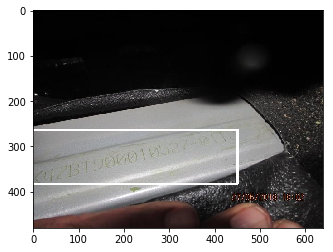

In [119]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

Now, we can get started with our image augmentations. The first one is **Horizontal Flipping**. The function takes one arguement, *p* which is the probability that the image will be flipped. 

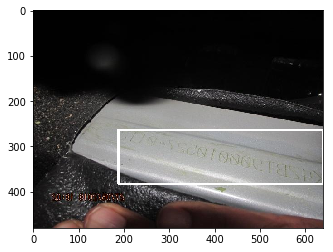

[[188.16 263.52 640.   383.52   0.  ]]


In [120]:
img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()
print(bboxes_)

**Scaling**. Scales the image. If the argument *diff* is True, then the image is scaled with different values in the vertical and the horizontal directions, i.e. aspect ratio is not maintained. 

If the first argument is a float, then the scaling factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

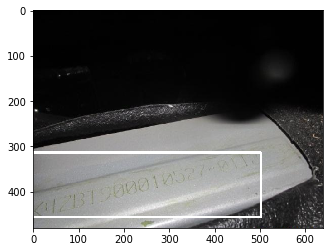

In [121]:
img_, bboxes_ = RandomScale(0.25, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Translation**. Translates the image. If the argument *diff* is True, then the image is translated with different values in the vertical and the horizontal directions.

If the first argument is a float, then the translating factors for both x and y directions are randomly sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

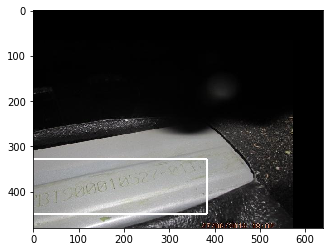

In [122]:
img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Rotation**. Rotates the image. 

If the first argument is a int, then the rotating angle, in degrees, is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

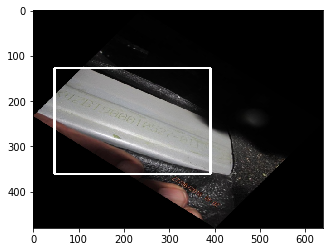

In [123]:
img_, bboxes_ = RandomRotate(40)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Shearing**. Sheares the image horizontally

If the first argument is a float, then the shearing factor is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

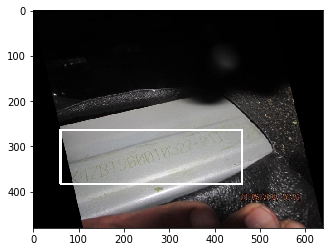

In [124]:
img_, bboxes_ = RandomShear(0.6)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Resizing**.  Resizes the image to square dimensions while keeping the aspect ratio constant.

The argument to this augmentation is the side of the square.

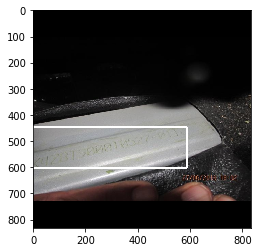

In [125]:
img_, bboxes_ = Resize(832)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

HSV transforms are supported as well. 

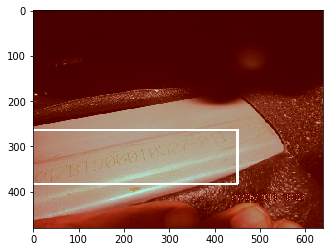

In [126]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

You can combine multiple transforms together by using the Sequence class as follows. 

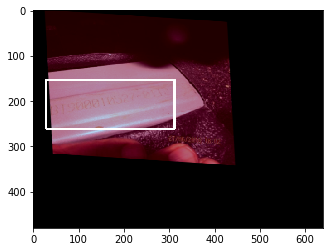

In [127]:
seq = Sequence([RandomHSV(40, 40, 30), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())

plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

A list of all possible transforms can be found in the `docs` folder.




